In [82]:

import os
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)
from matplotlib.lines import Line2D

import numpy.ma as ma

In [80]:
src = "/home/andres/data/hbmep-processed/J_SHAP/data.csv"
df = pd.read_csv(src)

In [81]:
file = open("/home/andres/repos/rat-mapping-paper/reports/J_SHAP/combine.pkl","rb")
combo = pickle.load(file)

In [102]:
#Create a numpy array that takes the posterior samples of specific muscles at specific positions
# posmusc = [("C6M-C6L", "LBiceps"), ("C7M-C7L", "LECR"), ("C8M-C8L", "LBiceps"),("C6L-C6M", "LBiceps"), ("C7L-C7M", "LECR"), ("C8L-C8M", "LBiceps")] #Data Driven
posmusc = [("C6M-C6L", "LBiceps"), ("C7M-C7L", "LTriceps"), ("C8M-C8L", "LADM"),("C6L-C6M", "LBiceps"), ("C7L-C7M", "LTriceps"), ("C8L-C8M", "LADM")] #Biologically Driven

shapes = ["50-0-50-100", "20-0-80-25", "50-0-50-0"]
directions = ['L-M', 'M-L']
levels = ['C6','C7', 'C8']
subjects = list(set([k[0] for k in combo.keys()]))
subjects.sort()
mask = []

a = [] 
mask = []

for s in subjects:
    for c in shapes:
        for d in directions:
            for level in levels:
                l, r = d.split("-")
                position = level + l +"-"+level + r
                for p in posmusc: 
                    if position == p[0]:
                        muscle = p[1]
                        key = (s, position, c, muscle)
                    if (key) in combo.keys():
                        currenta = combo[key]['a']
                        currenta = currenta.reshape(-1, 1)
                        a.append(currenta)
                        mask.append(np.full((4000, 1), False))
                    else:
                        a.append(np.zeros(4000).reshape(-1, 1))
                        mask.append(np.full((4000, 1), True))

arr = np.array(a)
arr = arr.reshape(len(subjects), len(shapes), len(directions), len(levels),len(posmusc), *arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(shapes), len(directions), len(levels),len(posmusc), *mask.shape[1:])

arr = ma.masked_array(arr, mask=mask)
arr = arr[..., 0]

In [103]:
arr.shape

(8, 3, 2, 3, 6, 4000)

In [104]:
pvalues = []
mask = []
data = []
means =[]
labels = []

for l_direction_ind, l_direction in enumerate(directions):
    for l_charge_ind, l_charge in enumerate(shapes):
        label = f"{l_direction}: {l_charge}"
        labels.append(label)
        
        for r_direction_ind, r_direction in enumerate(directions):
            for r_charge_ind, r_charge in enumerate(shapes):
                
                if (l_direction == r_direction) and (l_charge == r_charge):
                    pvalues.append(1)
                    mask.append(True)
                    data.append(label)
                    means.append(0)
                    continue
                
                mask.append(False)

                l_samples = arr[:, l_direction_ind,:, l_charge_ind, ...] # sub, seg, muscle, # posterior_samples
                r_samples = arr[:, r_direction_ind,:, r_charge_ind, ...]
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1, 2)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(6, 6)

mask = np.array(mask)
mask = mask.reshape(6, 6)

data = np.array(data)
data = data.reshape(6, 6)

means = np.array(means)
means = means.reshape(6, 6)

pvalues.shape

(6, 6)

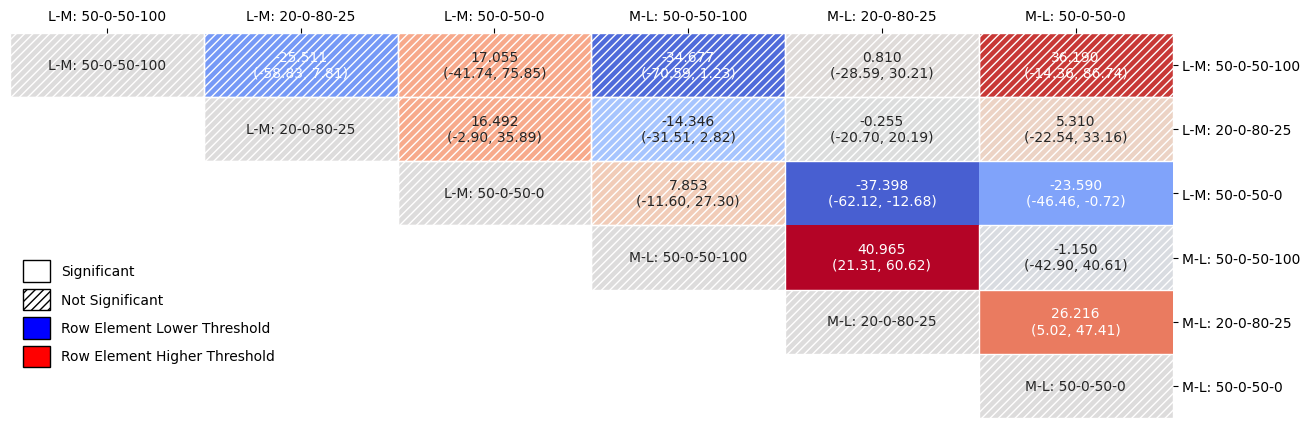

In [105]:
mask2= mask
mask2 = np.tril(np.ones_like(mask2), k=-1)
mask2 = mask2

plt.figure(figsize=(15, 5))
values = means
handles = []
cmap = 'coolwarm'
ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
plt.xticks(rotation=45);
hatch_mask = pvalues > 0.05

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()

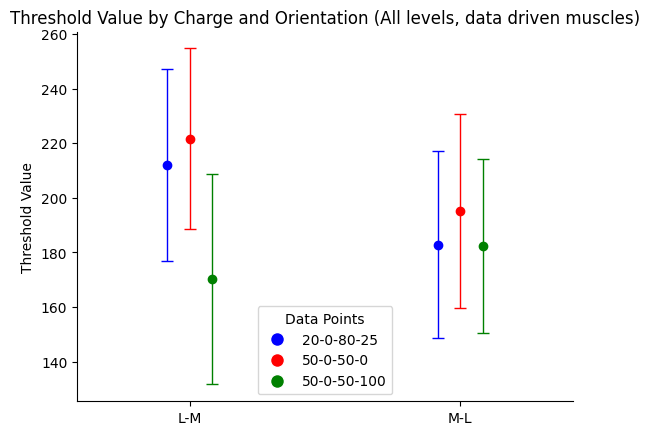

In [12]:
xpoint = [x[0] for x in thresh_list]
ypoint = [x[2] for x in thresh_list]
sem = [x[3] for x in thresh_list]
cols = [x[1] for x in thresh_list]
xpoint_new = [-.1, 0,.1, 1.1, 1.2, 1.3]
# sns.scatterplot(x=[x[0] for x in thresh_list], y=[x[2] for x in thresh_list], hue=[x[1] for x in thresh_list])
plt.xlim((-.5,1.7))
sns.despine()
plt.xticks([0, 1.2], ["L-M", "M-L"])
plt.ylabel("Threshold Value")
plt.title("Threshold Value by Charge and Orientation (All levels, data driven muscles)")

# labels = ['M-L', 'M-LL', 'M-LM1', 'M-LM2', 'M-L', 'M-LL', 'M-LM']

color_dict = {'20-0-80-25': 'blue', '50-0-50-0': 'red', '50-0-50-100': 'green'}
colors = [color_dict[col] for col in cols]
unique_labels = list(color_dict.keys())

for y, x, e, c in zip(xpoint_new, ypoint, sem, colors):
    plt.errorbar(y, x, yerr=e, fmt='o', color=c, elinewidth=1, capsize=4, ecolor=c)

legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10, label=label)
                  for label in unique_labels]
plt.legend(handles=legend_handles, title='Data Points')


Analysis based on Biological Muscle Innervation

In [13]:
#Create a numpy array that takes the posterior samples of specific muscles at specific positions
posmusc = [("C6M-C6L", "LBiceps"), ("C7M-C7L", "LTriceps"), ("C8M-C8L", "LADM"),("C6L-C6M", "LBiceps"), ("C7L-C7M", "LTriceps"), ("C8L-C8M", "LADM")]
charges = ["20-0-80-25", "50-0-50-0", "50-0-50-100"]
subjects = list(set([k[0] for k in combo.keys()]))
subjects.sort()

b = None
for s in subjects:
    for c in charges:
        for p in posmusc:
            pos = p[0]
            musc = p[1]
            if (s, pos, c, musc) in combo.keys():
                samples = combo[(s, pos, c, musc)][site.a]
                samples = samples.reshape(-1, 1)

                if b is None: b = samples
                else: b = np.concatenate((b, samples), axis=1)
            else:continue

b = b.reshape(-1, len(subjects), len(charges), 2, 2)
b.shape

(4000, 8, 3, 2, 2)

In [14]:
ind = 1
for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = b[:, :, :, ind, ...][:, :, i, ...]
        r_samples = b[:, :, :, ind, ...][:, :, j, ...]
        l_samples = l_samples.mean(axis=0)
        r_samples = r_samples.mean(axis=0)

        pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="less", popmean=0, axis=(0,1)
        ).pvalue
        print(
            f"{l}\t<\t{r}:\t\t{pvalue}"
        )
    

20-0-80-25	<	50-0-50-0:		0.36205547438013613
20-0-80-25	<	50-0-50-100:		0.5490962841661448
50-0-50-0	<	20-0-80-25:		0.6379445256198639
50-0-50-0	<	50-0-50-100:		0.664245346205951
50-0-50-100	<	20-0-80-25:		0.45090371583385525
50-0-50-100	<	50-0-50-0:		0.3357546537940491


In [15]:
#Compare 7L-M to 7M-L
for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        l_samples = b[:, :, :, 0, ...][:, :, i, ...]
        r_samples = b[:, :, :, 1, ...][:, :, j, ...]
        l_samples = l_samples.mean(axis=0)
        r_samples = r_samples.mean(axis=0)

        pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="less", popmean=0, axis=(0,1)
        ).pvalue
        r_pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="greater", popmean=0, axis=(0,1)
        ).pvalue
        print(
            f"L-M {l}\t<\t M-L {r}: \t\t{pvalue} \t\t L-M > M-L \t\t{r_pvalue}"
        )

L-M 20-0-80-25	<	 M-L 20-0-80-25: 		0.6236877750756683 		 L-M > M-L 		0.3763122249243317
L-M 20-0-80-25	<	 M-L 50-0-50-0: 		0.44736372542238506 		 L-M > M-L 		0.552636274577615
L-M 20-0-80-25	<	 M-L 50-0-50-100: 		0.6909890384592223 		 L-M > M-L 		0.3090109615407777
L-M 50-0-50-0	<	 M-L 20-0-80-25: 		0.8223651147487117 		 L-M > M-L 		0.17763488525128834
L-M 50-0-50-0	<	 M-L 50-0-50-0: 		0.7598877424138042 		 L-M > M-L 		0.24011225758619575
L-M 50-0-50-0	<	 M-L 50-0-50-100: 		0.8822281511257809 		 L-M > M-L 		0.11777184887421913
L-M 50-0-50-100	<	 M-L 20-0-80-25: 		0.06758129100512451 		 L-M > M-L 		0.9324187089948756
L-M 50-0-50-100	<	 M-L 50-0-50-0: 		0.09156693015450937 		 L-M > M-L 		0.9084330698454907
L-M 50-0-50-100	<	 M-L 50-0-50-100: 		0.05737581238868247 		 L-M > M-L 		0.9426241876113175


In [16]:
LM = b[:, :,:,0, ...]
ML = b[:, :,:,1, ...]


thresh_list = []
for i, l in enumerate(charges):
    l_samples = LM[:, :, i, ...].mean(axis=0)
    sem = stats.sem(l_samples, axis=(0, 1))
    thresh_list.append(["L-M", l, l_samples.mean(), sem])

for i, r in enumerate(charges):
    m_samples = ML[:, :, i, ...].mean(axis=0)
    sem = stats.sem(m_samples, axis=(0, 1))
    thresh_list.append(["M-L",r, m_samples.mean(), sem])

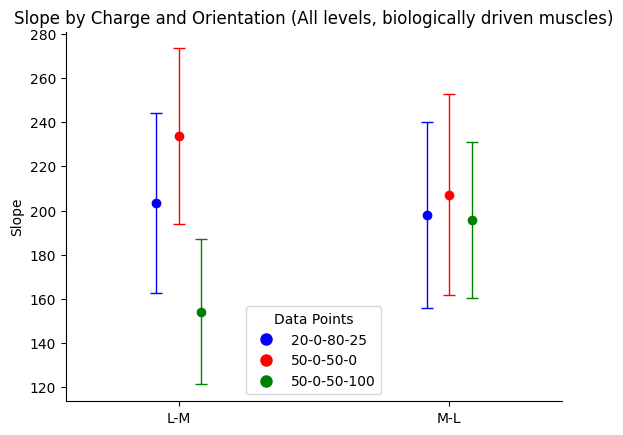

In [17]:
xpoint = [x[0] for x in thresh_list]
ypoint = [x[2] for x in thresh_list]
sem = [x[3] for x in thresh_list]
cols = [x[1] for x in thresh_list]
xpoint_new = [-.1, 0,.1, 1.1, 1.2, 1.3]
# sns.scatterplot(x=[x[0] for x in thresh_list], y=[x[2] for x in thresh_list], hue=[x[1] for x in thresh_list])
plt.xlim((-.5,1.7))
sns.despine()
plt.xticks([0, 1.2], ["L-M", "M-L"])
plt.ylabel("Slope")
plt.title("Slope by Charge and Orientation (All levels, biologically driven muscles)")

# labels = ['M-L', 'M-LL', 'M-LM1', 'M-LM2', 'M-L', 'M-LL', 'M-LM']

color_dict = {'20-0-80-25': 'blue', '50-0-50-0': 'red', '50-0-50-100': 'green'}
colors = [color_dict[col] for col in cols]
unique_labels = list(color_dict.keys())

for y, x, e, c in zip(xpoint_new, ypoint, sem, colors):
    plt.errorbar(y, x, yerr=e, fmt='o', color=c, elinewidth=1, capsize=4, ecolor=c)

legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10, label=label)
                  for label in unique_labels]
plt.legend(handles=legend_handles, title='Data Points')


In [18]:
set([k[1] for k in combo.keys()])

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}